In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import brainiak
import nilearn as nl
from nilearn import image, plotting, input_data

from scipy.spatial import distance

In [9]:
sub_ns = np.arange(30,39) # available subjects

### fix broken paths

In [10]:
def load_sub4d(sub_n,task='videos',max_len=2000,numpy_output=True):
  """ 
  task = videos / recall2 
  """
  ses = 2
  fpath = 'fmri_data/func/sub-1%i_ses-0%i_task-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii'%(sub_n,ses,task)
  try:
    img = nl.image.load_img(fpath)
  except:
    print('NOT FOUND:',fpath)
    return None
  img = img.slicer[:,:,:,:max_len] # lengths differ
  if numpy_output:
    img = img.get_fdata() # nilearn into np
  return img

In [11]:
task = 'videos'
group4d = []
n_subs = 1

## load subject 4d data
for sub_n in sub_ns[:n_subs]:
  sub4d = load_sub4d(sub_n,task)
  group4d.append(sub4d)
  print(sub4d.shape)
  
## group array
group4d = np.stack(group4d)
print(group4d.shape)

(97, 115, 97, 1168)


KeyboardInterrupt: 

# ROI

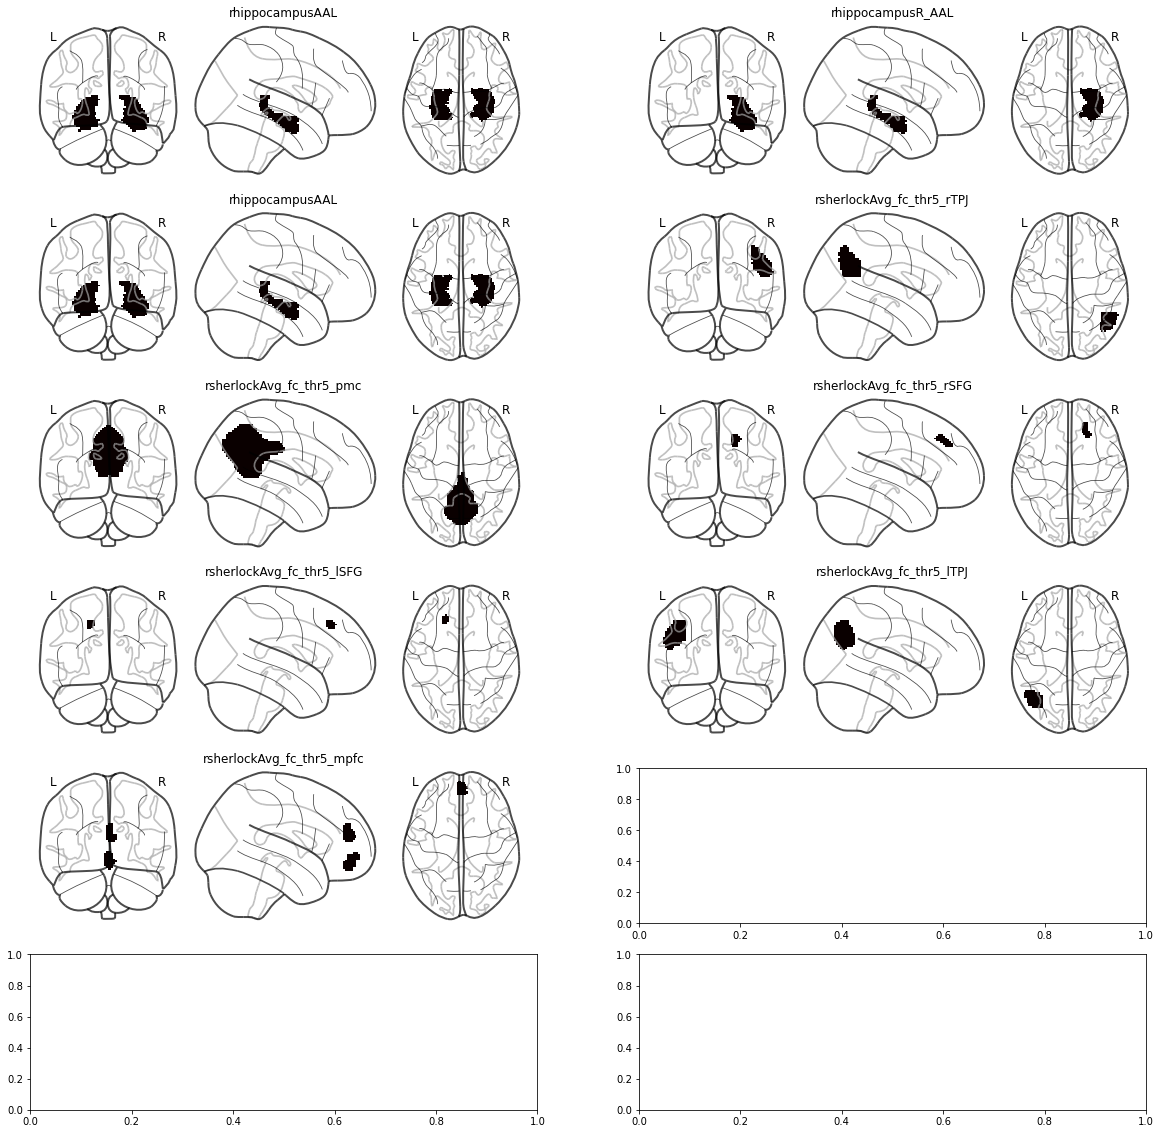

In [7]:
fig,axarr = plt.subplots(6,2,figsize=(20,20)); axarr=axarr.reshape(-1)
roiL = ['rhippocampusAAL','rhippocampusR_AAL','rhippocampusAAL','rsherlockAvg_fc_thr5_rTPJ','rsherlockAvg_fc_thr5_pmc','rsherlockAvg_fc_thr5_rSFG',
       'rsherlockAvg_fc_thr5_lSFG','rsherlockAvg_fc_thr5_lTPJ','rsherlockAvg_fc_thr5_mpfc']
roiD = {}
for roi_idx in range(len(roiL)):
  roi_name = roiL[roi_idx]
  ax = axarr[roi_idx]
  ax.set_title(roi_name)
  roi_img = nl.image.load_img("fmri_data/rois/%s.nii"%roi_name)
  roiD[roi_name]=roi_img
  nl.plotting.plot_glass_brain(roi_img,axes=ax)

In [66]:
nifti_masker = nl.input_data.NiftiMasker(mask_img=roiD['rsherlockAvg_fc_thr5_lTPJ'],  high_pass=1/128, t_r=1.5)
sub4d = load_sub4d(30,task='videos',max_len=1160,numpy_output=False)
print(sub4d.shape)
sub4d_masked = nifti_masker.fit_transform(sub4d)
print(sub4d_masked.shape)

(97, 115, 97, 1160)
(1160, 877)


In [14]:
## script 
roi_nameL = [
  'rsherlockAvg_fc_thr5_rTPJ','rsherlockAvg_fc_thr5_pmc',
  'rsherlockAvg_fc_thr5_rSFG','rsherlockAvg_fc_thr5_lSFG',
  'rsherlockAvg_fc_thr5_lTPJ','rsherlockAvg_fc_thr5_mpfc',
  'rhippocampusL_AAL','rhippocampusR_AAL',
  'rhippocampusAAL']

for sub_n in sub_ns[:1]:
  # load subj
  sub4d = load_sub4d(sub_n,task='videos',max_len=2000,numpy_output=False)
  for roi_name in roi_nameL[:1]:
    # load mask
    roi_img = nl.image.load_img("fmri_data/rois/%s.nii"%roi_name)
    # plt masks
    plt.figure(figsize=(3,8))
    nl.plotting.plot_glass_brain(roi_img)
    plt.savefig('figures/masks/%s'%roi_name)
    plt.close('all')
    # init & apply mask
    nifti_masker = nl.input_data.NiftiMasker(mask_img=roi_img,high_pass=1/128,t_r=1.5)
    sub4d_masked = nifti_masker.fit_transform(sub4d)
    save_fpath = "sub-%i_%s"%(sub_n,roi_name)
    np.save('fmri_data/masked/%s'%save_fpath,sub4d_masked)
  
sub4d_masked.shape,type(sub4d_masked)

((1168, 868), numpy.ndarray)

# Time RSA

In [88]:
cormat = distance.cdist(sub4d_masked,sub4d_masked,metric='correlation')
cormat.shape

(1160, 1160)

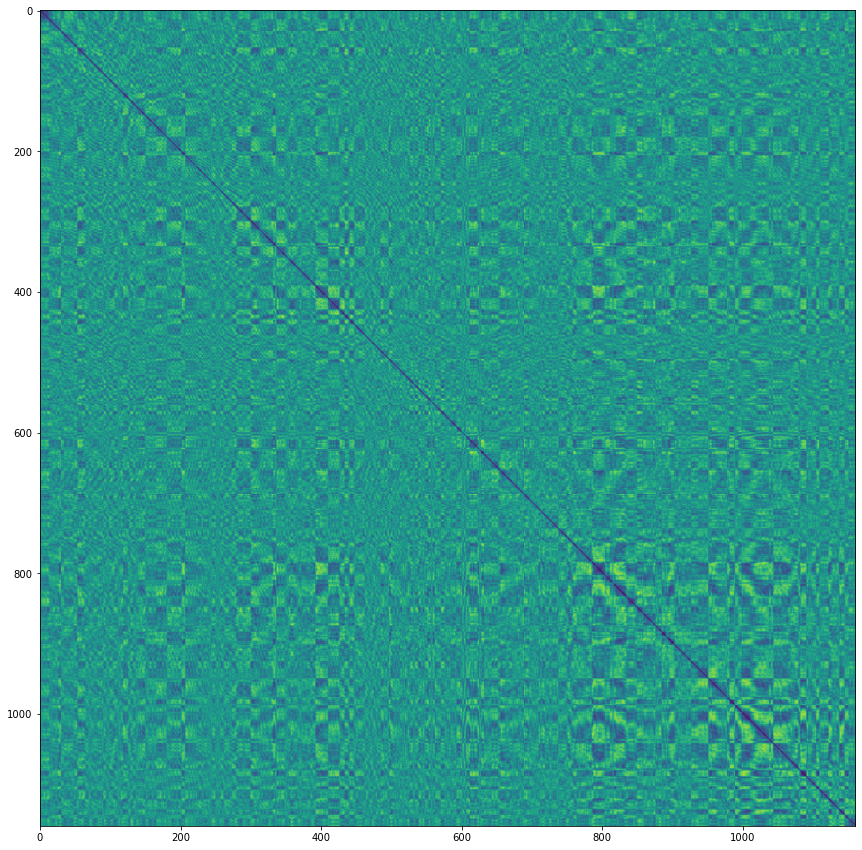

In [91]:
plt.figure(figsize=(15,15))
plt.imshow(cormat)
plt.savefig('figures/RSAimshow_sherlockTPJ_subject30')